<a href="https://colab.research.google.com/github/BHARATH077/ETL_Customer_Behavior/blob/main/ETL_Customer_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL Pipeline for Customer Behavior Analytics

# Data Ingestion

In [1]:
# Install Dependencies
# Install Spark + DuckDB
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark duckdb pandas seaborn matplotlib


In [2]:
# Verify Spark and DuckBD

import pyspark
from pyspark.sql import SparkSession
import duckdb

# Start Spark session
spark = SparkSession.builder.appName("ETL_Project").getOrCreate()
print("Spark Version:", spark.version)

# Connect to DuckDB (in-memory for now)
con = duckdb.connect(":memory:")
print("DuckDB connected:", con)


Spark Version: 3.5.1
DuckDB connected: <duckdb.duckdb.DuckDBPyConnection object at 0x7aa6c840aeb0>


In [3]:
# Prepare Sample Data
# Since we don’t have real APIs/DBs yet, I’ll mock some CSV & JSON files directly in Colab (later we can replace them).

import pandas as pd
import json

# Clickstream CSV
clickstream_data = {
    "session_id": [1,2,3,4,5],
    "customer_id": [101,102,101,103,104],
    "page_viewed": ["Home","Product","Cart","Home","Checkout"],
    "timestamp": ["2024-01-01 10:00","2024-01-01 10:05","2024-01-01 10:10","2024-01-02 12:00","2024-01-02 12:15"]
}
pd.DataFrame(clickstream_data).to_csv("clickstream.csv", index=False)

# Transactions CSV
transactions_data = {
    "transaction_id": [1001,1002,1003],
    "customer_id": [101,102,104],
    "amount": [250.0, 100.0, 75.0],
    "timestamp": ["2024-01-01 11:00","2024-01-01 11:05","2024-01-02 12:30"]
}
pd.DataFrame(transactions_data).to_csv("transactions.csv", index=False)

# CRM JSON
crm_data = [
    {"customer_id":101, "name":"Alice","segment":"Premium"},
    {"customer_id":102, "name":"Bob","segment":"Standard"},
    {"customer_id":103, "name":"Charlie","segment":"Standard"},
    {"customer_id":104, "name":"Diana","segment":"Premium"}
]
with open("crm.json","w") as f:
    json.dump(crm_data,f)

print("Raw data recreated ✅")


Raw data recreated ✅


In [4]:
# Read Raw Data Files
import pandas as pd
import json

# Read Clickstream CSV
clickstream_df = pd.read_csv("clickstream.csv")
print("Clickstream:")
print(clickstream_df.head())

# Read Transactions CSV
transactions_df = pd.read_csv("transactions.csv")
print("\nTransactions:")
print(transactions_df.head())

# Read CRM JSON
with open("crm.json") as f:
    crm_df = pd.json_normalize(json.load(f))
print("\nCRM:")
print(crm_df.head())


Clickstream:
   session_id  customer_id page_viewed         timestamp
0           1          101        Home  2024-01-01 10:00
1           2          102     Product  2024-01-01 10:05
2           3          101        Cart  2024-01-01 10:10
3           4          103        Home  2024-01-02 12:00
4           5          104    Checkout  2024-01-02 12:15

Transactions:
   transaction_id  customer_id  amount         timestamp
0            1001          101   250.0  2024-01-01 11:00
1            1002          102   100.0  2024-01-01 11:05
2            1003          104    75.0  2024-01-02 12:30

CRM:
   customer_id     name   segment
0          101    Alice   Premium
1          102      Bob  Standard
2          103  Charlie  Standard
3          104    Diana   Premium


In [5]:
# Load into DuckDB
import duckdb

# Create DuckDB connection
con = duckdb.connect(database=':memory:')

# Load Pandas DataFrames into DuckDB
con.register("clickstream_df", clickstream_df)
con.register("transactions_df", transactions_df)
con.register("crm_df", crm_df)

# Create DuckDB tables
con.execute("CREATE TABLE clickstream AS SELECT * FROM clickstream_df")
con.execute("CREATE TABLE transactions AS SELECT * FROM transactions_df")
con.execute("CREATE TABLE crm AS SELECT * FROM crm_df")

# Verify
print(con.execute("SHOW TABLES").fetchdf())


              name
0      clickstream
1   clickstream_df
2              crm
3           crm_df
4     transactions
5  transactions_df


In [6]:
# Run First Warehouse Queries

# Count clickstream sessions
print(con.execute("SELECT COUNT(*) as sessions FROM clickstream").fetchdf())

# Check total transactions
print(con.execute("SELECT COUNT(*) as transactions FROM transactions").fetchdf())

# Join CRM with Transactions (quick test)
query = """
SELECT c.customer_id, c.name, c.segment, SUM(t.amount) as total_spend
FROM crm c
LEFT JOIN transactions t
ON c.customer_id = t.customer_id
GROUP BY c.customer_id, c.name, c.segment
"""
print(con.execute(query).fetchdf())


   sessions
0         5
   transactions
0             3
   customer_id     name   segment  total_spend
0          101    Alice   Premium        250.0
1          104    Diana   Premium         75.0
2          103  Charlie  Standard          NaN
3          102      Bob  Standard        100.0


# Data Cleaning & Transformation with PySpark

In [7]:
# Install and import Spark

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, upper

# Start Spark session
spark = SparkSession.builder.appName("ETL_Cleaning").getOrCreate()


In [8]:
# Load Data into Spark
# Load CSVs into Spark DataFrames
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, upper

spark = SparkSession.builder.appName("ETL_Cleaning").getOrCreate()

clickstream_spark = spark.read.csv("clickstream.csv", header=True, inferSchema=True)
transactions_spark = spark.read.csv("transactions.csv", header=True, inferSchema=True)
crm_spark = spark.read.json("crm.json")

# Load JSON CRM into Spark
crm_spark = spark.read.json("crm.json")

print("Clickstream:")
clickstream_spark.show()
print("Transactions:")
transactions_spark.show()
print("CRM:")
crm_spark.show()


Clickstream:
+----------+-----------+-----------+-------------------+
|session_id|customer_id|page_viewed|          timestamp|
+----------+-----------+-----------+-------------------+
|         1|        101|       Home|2024-01-01 10:00:00|
|         2|        102|    Product|2024-01-01 10:05:00|
|         3|        101|       Cart|2024-01-01 10:10:00|
|         4|        103|       Home|2024-01-02 12:00:00|
|         5|        104|   Checkout|2024-01-02 12:15:00|
+----------+-----------+-----------+-------------------+

Transactions:
+--------------+-----------+------+-------------------+
|transaction_id|customer_id|amount|          timestamp|
+--------------+-----------+------+-------------------+
|          1001|        101| 250.0|2024-01-01 11:00:00|
|          1002|        102| 100.0|2024-01-01 11:05:00|
|          1003|        104|  75.0|2024-01-02 12:30:00|
+--------------+-----------+------+-------------------+

CRM:
+-----------+-------+--------+
|customer_id|   name| segment|

In [9]:
# Basic Cleaning

# --- Step 2: Cleaning / Transformation ---
clickstream_spark = clickstream_spark.withColumn("timestamp", to_timestamp("timestamp")).na.drop(subset=["customer_id"])
transactions_spark = transactions_spark.withColumn("timestamp", to_timestamp("timestamp")).na.drop(subset=["customer_id"])
crm_spark = crm_spark.withColumn("segment", upper(col("segment"))).na.drop(subset=["customer_id"])

# --- Step 3: Convert Spark DF back to Pandas ---
clickstream_clean = clickstream_spark.toPandas()
transactions_clean = transactions_spark.toPandas()
crm_clean = crm_spark.toPandas()


In [10]:
# Save Cleaned Data
# --- Step 4: Register Pandas DF into DuckDB ---
import duckdb
con = duckdb.connect(":memory:")

con.register("clickstream_clean", clickstream_clean)
con.register("transactions_clean", transactions_clean)
con.register("crm_clean", crm_clean)

print("DuckDB tables registered ✅")
print(con.execute("SHOW TABLES").fetchdf())


DuckDB tables registered ✅
                 name
0   clickstream_clean
1           crm_clean
2  transactions_clean


In [11]:
# Verify Cleaning

query = """
SELECT c.customer_id, c.name, c.segment, COUNT(s.session_id) as sessions, SUM(t.amount) as total_spend
FROM crm_clean c
LEFT JOIN clickstream_clean s ON c.customer_id = s.customer_id
LEFT JOIN transactions_clean t ON c.customer_id = t.customer_id
GROUP BY c.customer_id, c.name, c.segment
"""
print(con.execute(query).fetchdf())


   customer_id     name   segment  sessions  total_spend
0          101    Alice   PREMIUM         2        500.0
1          102      Bob  STANDARD         1        100.0
2          104    Diana   PREMIUM         1         75.0
3          103  Charlie  STANDARD         1          NaN


# Transformations for Analytics

In [12]:
import duckdb

# Connect to DuckDB in-memory
con = duckdb.connect(database=':memory:')

# Register Pandas DataFrames into DuckDB
con.register("clickstream_clean", clickstream_clean)
con.register("transactions_clean", transactions_clean)
con.register("crm_clean", crm_clean)



# Creating Feature tables

In [13]:
# Sessions per Customer (Engagement)

sessions_query = """
SELECT customer_id, COUNT(DISTINCT session_id) AS session_count
FROM clickstream_clean
GROUP BY customer_id
"""
sessions_df = con.execute(sessions_query).fetchdf()
print(sessions_df)


   customer_id  session_count
0          102              1
1          101              2
2          103              1
3          104              1


In [14]:
# Purchases and Spend per Customer

spend_query = """
SELECT customer_id, COUNT(DISTINCT transaction_id) AS purchase_count, SUM(amount) AS total_spend
FROM transactions_clean
GROUP BY customer_id
"""
spend_df = con.execute(spend_query).fetchdf()
print(spend_df)


   customer_id  purchase_count  total_spend
0          102               1        100.0
1          101               1        250.0
2          104               1         75.0


In [15]:
# Most Viewed Pages per Customer

page_query = """
SELECT customer_id, page_viewed, COUNT(*) AS views
FROM clickstream_clean
GROUP BY customer_id, page_viewed
QUALIFY ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY views DESC) = 1
"""
page_df = con.execute(page_query).fetchdf()
print(page_df)


   customer_id page_viewed  views
0          102     Product      1
1          101        Home      1
2          103        Home      1
3          104    Checkout      1


In [16]:
# Define subqueries as strings
sessions_query = """
SELECT customer_id, COUNT(DISTINCT session_id) AS session_count
FROM clickstream_clean
GROUP BY customer_id
"""

spend_query = """
SELECT customer_id, COUNT(DISTINCT transaction_id) AS purchase_count, SUM(amount) AS total_spend
FROM transactions_clean
GROUP BY customer_id
"""

page_query = """
SELECT customer_id, page_viewed, COUNT(*) AS views
FROM clickstream_clean
GROUP BY customer_id, page_viewed
QUALIFY ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY views DESC) = 1
"""

# Combine using f-string to inject subqueries
customer360_query = f"""
SELECT c.customer_id, c.name, c.segment,
       COALESCE(s.session_count, 0) AS sessions,
       COALESCE(sp.purchase_count, 0) AS purchases,
       COALESCE(sp.total_spend, 0) AS spend,
       COALESCE(p.page_viewed, 'N/A') AS top_page
FROM crm_clean c
LEFT JOIN ({sessions_query}) s ON c.customer_id = s.customer_id
LEFT JOIN ({spend_query}) sp ON c.customer_id = sp.customer_id
LEFT JOIN ({page_query}) p ON c.customer_id = p.customer_id
"""

# Execute query
customer360 = con.execute(customer360_query).fetchdf()
print(customer360)


   customer_id     name   segment  sessions  purchases  spend  top_page
0          101    Alice   PREMIUM         2          1  250.0      Home
1          102      Bob  STANDARD         1          1  100.0   Product
2          104    Diana   PREMIUM         1          1   75.0  Checkout
3          103  Charlie  STANDARD         1          0    0.0      Home


In [17]:
# Save Outputs

customer360.to_csv("customer360_day4.csv", index=False)


# Analytics & Visualization

In [18]:
# Step 1: Load Customer 360 Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Customer 360
customer360 = pd.read_csv("customer360_day4.csv")
print(customer360.head())


   customer_id     name   segment  sessions  purchases  spend  top_page
0          101    Alice   PREMIUM         2          1  250.0      Home
1          102      Bob  STANDARD         1          1  100.0   Product
2          104    Diana   PREMIUM         1          1   75.0  Checkout
3          103  Charlie  STANDARD         1          0    0.0      Home


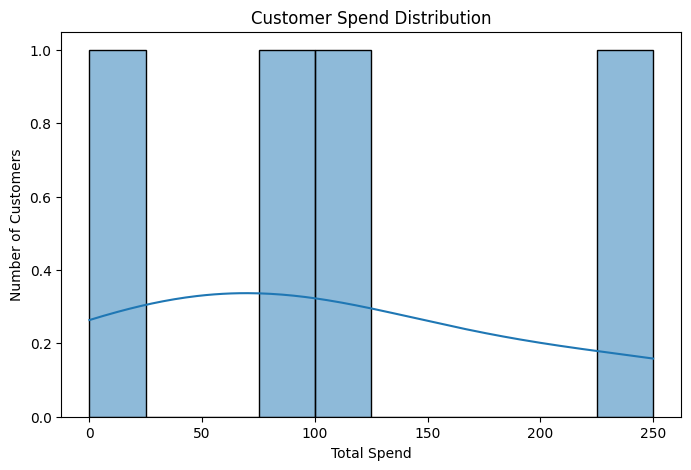

In [19]:
# Step 2: Distribution of Customer Spend
plt.figure(figsize=(8,5))
sns.histplot(customer360['spend'], bins=10, kde=True)
plt.title("Customer Spend Distribution")
plt.xlabel("Total Spend")
plt.ylabel("Number of Customers")
plt.show()


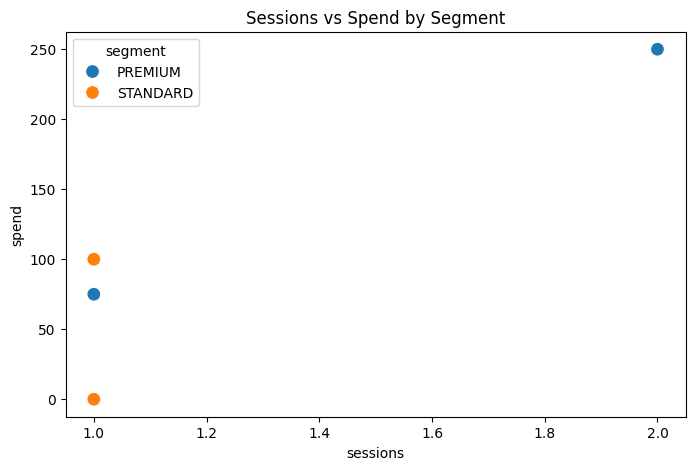

In [20]:
# Step 3: Sessions vs. Spend
plt.figure(figsize=(8,5))
sns.scatterplot(data=customer360, x="sessions", y="spend", hue="segment", s=100)
plt.title("Sessions vs Spend by Segment")
plt.show()


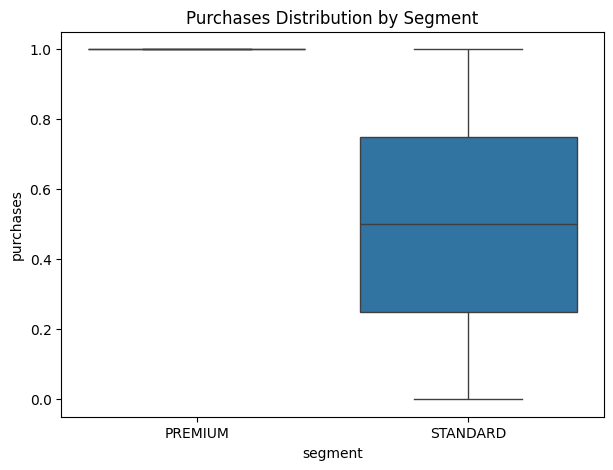

In [21]:
# Step 4: Purchases by Segment
plt.figure(figsize=(7,5))
sns.boxplot(data=customer360, x="segment", y="purchases")
plt.title("Purchases Distribution by Segment")
plt.show()


/tmp/ipython-input-3355940236.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pages.index, y=top_pages.values, palette="viridis")


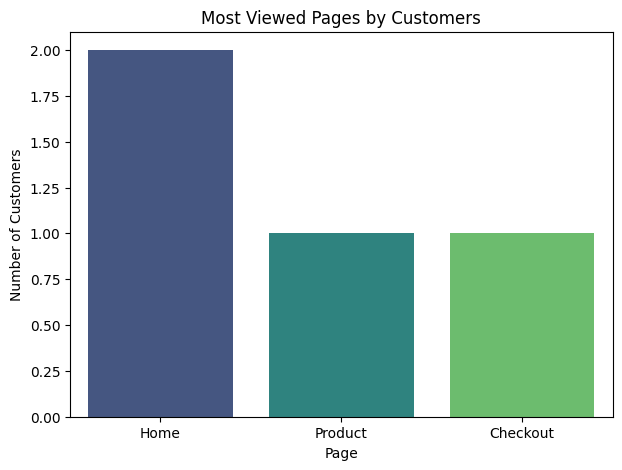

In [22]:
# Step 5: Most Viewed Pages
top_pages = customer360['top_page'].value_counts()

plt.figure(figsize=(7,5))
sns.barplot(x=top_pages.index, y=top_pages.values, palette="viridis")
plt.title("Most Viewed Pages by Customers")
plt.xlabel("Page")
plt.ylabel("Number of Customers")
plt.show()


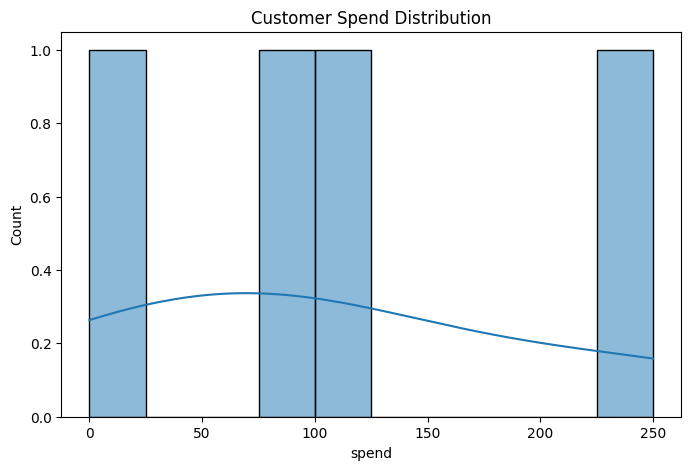

In [23]:
# Step 6: Save Visual Report
# Save summary stats
customer360.describe().to_csv("customer360_summary.csv")

# Save one figure
plt.figure(figsize=(8,5))
sns.histplot(customer360['spend'], bins=10, kde=True)
plt.title("Customer Spend Distribution")
plt.savefig("spend_distribution.png")


# Dashboard Setup

In [24]:
# Step 1: Prepare Data for Dashboard
import pandas as pd

# Load Customer360
customer360 = pd.read_csv("customer360_day4.csv")

# Check for missing values
print(customer360.isnull().sum())

# Replace NAs (if any)
customer360 = customer360.fillna({"spend":0, "purchases":0, "sessions":0})

# Save cleaned version
customer360.to_csv("customer360_dashboard.csv", index=False)


customer_id    0
name           0
segment        0
sessions       0
purchases      0
spend          0
top_page       0
dtype: int64


In [25]:
# Step 2: Upload to Google Drive
from google.colab import files
files.download("customer360_dashboard.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Open Looker Studio for visuals(Link in Github)

# Airflow Orchestration (Simulated). DAG is created in a different notebook.

# Monitoring & Logging

In [26]:
# Step 1: Add Logging to ETL Tasks
import pandas as pd
import time
from datetime import datetime

# Simple logger function
def log_event(task_name, status, logfile="etl_logs.csv"):
    log = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "task": task_name,
        "status": status
    }
    log_df = pd.DataFrame([log])
    log_df.to_csv(logfile, mode='a', header=not pd.io.common.file_exists(logfile), index=False)

def extract():
    try:
        log_event("extract", "started")
        clickstream = pd.read_csv("clickstream.csv")
        transactions = pd.read_csv("transactions.csv")
        crm = pd.read_csv("crm.csv")
        clickstream.to_csv("/tmp/clickstream_raw.csv", index=False)
        transactions.to_csv("/tmp/transactions_raw.csv", index=False)
        crm.to_csv("/tmp/crm_raw.csv", index=False)
        log_event("extract", "success")
    except Exception as e:
        log_event("extract", f"failed: {e}")
        raise

def transform():
    try:
        log_event("transform", "started")
        clickstream = pd.read_csv("/tmp/clickstream_raw.csv")
        transactions = pd.read_csv("/tmp/transactions_raw.csv")
        crm = pd.read_csv("/tmp/crm_raw.csv")

        # Example transformation
        spend = transactions.groupby("customer_id")["amount"].sum().reset_index()
        sessions = clickstream.groupby("customer_id")["session_id"].nunique().reset_index()

        customer360 = crm.merge(spend, on="customer_id", how="left").merge(
            sessions, on="customer_id", how="left"
        )
        customer360.to_csv("/tmp/customer360.csv", index=False)
        log_event("transform", "success")
    except Exception as e:
        log_event("transform", f"failed: {e}")
        raise

def load():
    try:
        log_event("load", "started")
        df = pd.read_csv("/tmp/customer360.csv")
        df.to_csv("customer360_final.csv", index=False)
        log_event("load", "success")
    except Exception as e:
        log_event("load", f"failed: {e}")
        raise


In [28]:
# Step 2: Simulate DAG Run with Logs
# Simulate DAG run
extract()
transform()
load()

# Check log file
logs = pd.read_csv("etl_logs.csv")
print(logs)

# We can't see the logs here cause we don't have access to Airflow because it's not free!.

In [29]:
# Step 3: Add Visualization of Pipeline Health
import seaborn as sns
import matplotlib.pyplot as plt

status_counts = logs['status'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title("ETL Task Status Overview")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

# No Logs means No Visuals either.